importing the modules required for neural network

In [115]:
# import numpy as np
# import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split

# libraries for pipleline optimization
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
# from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# from skopt import gp_minimize
from skopt.space import Categorical
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# while using jupyter notebook
!pip install optuna
!pip install plotly

import optuna
import optuna.visualization as vis
import plotly
# references: https://knowledge.dataiku.com/latest/data-preparation/pipelines/concept-pipeline-optimization.html
#https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


libraries added to implement bayesian optimization

In [116]:
# import warnings
# from bayes_opt.constraint import ConstraintModel
# from bayes_opt import BayesianOptimization, UtilityFunction, util
# # from .target_space import TargetSpace
# # from .event import Events, DEFAULT_EVENTS
# # from .logger import _get_default_logger
# # from .util import UtilityFunction, acq_max, ensure_rng
# from sklearn.gaussian_process.kernels import Matern
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.metrics import roc_auc_score

importing the dataset

In [117]:
df = pd.read_csv("ercot-dataset.csv", sep=',')
# to change the float to two decimal places following code is used
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df = df.iloc[:80000]
print(df)

                   Date  DryBulb  DewPnt  WetBulb  Humidity  ElecPrice  Day  \
0         1/1/2006 6:30    24.70   21.75    22.75     84.00      14.35    1   
1         1/1/2006 5:00    23.50   21.70    22.30     90.00      14.99    1   
2         1/1/2006 5:30    23.75   21.70    22.40     88.50      15.08    1   
3         1/1/2006 6:00    24.00   21.70    22.50     87.00      15.16    1   
4         1/1/2006 4:30    23.50   21.70    22.30     90.00      15.20    1   
...                 ...      ...     ...      ...       ...        ...  ...   
87642  31/12/2010 15:00    26.00   19.70    21.90     68.00      47.15   31   
87643  31/12/2010 15:30    25.95   19.65    21.85     68.00      50.44   31   
87644  31/12/2010 17:00    25.40   19.30    21.50     69.00      50.44   31   
87645  31/12/2010 16:00    25.90   19.60    21.80     68.00      56.48   31   
87646  31/12/2010 16:30    25.65   19.45    21.65     68.50      61.17   31   

       Month  Year  Minutes  SYSLoad  
0          1

In [118]:
# prints the high level information about the data
df.info()
# gives additional statistical information
'''df.describe()'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87647 entries, 0 to 87646
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       87647 non-null  object 
 1   DryBulb    87647 non-null  float64
 2   DewPnt     87647 non-null  float64
 3   WetBulb    87647 non-null  float64
 4   Humidity   87647 non-null  float64
 5   ElecPrice  87647 non-null  float64
 6   Day        87647 non-null  int64  
 7   Month      87647 non-null  int64  
 8   Year       87647 non-null  int64  
 9   Minutes    87647 non-null  int64  
 10  SYSLoad    87647 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.4+ MB


'df.describe()'

In [119]:
# to check the total missing data on each features
# zero indicates there is no missing data values
df.isnull().sum()
#df1 = df.drop(['Date','Month','Year', 'Day','Minutes'], axis=1)
df1 = df.drop(['Date','Year'], axis=1)

In [120]:
# df1.corr()
# # to see the correlation between features
# # this helps to see how one parameters has effects on others
# # lets see the plot of correlation data
# sns.heatmap(df1.corr(), annot= True)
# plt.rcParams["figure.figsize"]=(15,10)
# plt.title('Correlation Matrix', fontsize=16)
# plt.show()

In [121]:
# this will select all the rows and columns except the last one from df and assign to x variable
# df1 does not contain the date in the first column in string format
X = df1.iloc[:,:-1].values
#x = df1.iloc[:,1].values
# quality is taken target variable and it in last column and is assigned to y variable
y = df1.iloc[:,-1].values
# encoding the categorical data using onehotencoder this is for classification tasks
'''ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')
x = ct.fit_transform(x)
x = x.toarray() # converts encoded data to dense array (optional) would show error without this'''

"ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')\nx = ct.fit_transform(x)\nx = x.toarray() # converts encoded data to dense array (optional) would show error without this"

Splitting the dataset into the training and test set

In [122]:
# we will split the data into training and testing data using following code
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean deviation of train data: {x_train.mean()}')

feature standardization and conversion to tensor

In [123]:
# Feature Scaling (not necessary for neural networks, but can be applied)
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

# # print(f'Standard deviation of test data: {x_test.std()}')
# # print(f'mean of test data: {x_test.mean()}')
# # print(f'Standard deviation of train data: {x_train.std()}')
# # print(f'mean of train data: {x_train.mean()}')
# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# # Create a PyTorch dataset and DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)
# len(X_train)
# #len(test_loader)

Pipeline Preprocessing is done using following code

In [124]:
X = pd.DataFrame(X)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combining both features, the value will be stored in preprocessor object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

preprocessor.fit(X)
# lets stored the preprocessed value to a variable
X = preprocessor.transform(X)

# spliting the dataset into train and test after the transformation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

check the model performance with the default preprocessing as defined in above cell

In [125]:
# Define the pipeline for Random Forest
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the parameter space for Random Forest
rf_param_space = {
    'regressor__n_estimators': Integer(10, 1000),
    'regressor__max_depth': Integer(3, 40),
    'regressor__min_samples_split': Integer(2, 10),
    'regressor__min_samples_leaf': Integer(1, 5)
}

# Perform hyperparameter optimization for Random Forest
rf_optimizer = BayesSearchCV(
    rf_pipeline, 
    rf_param_space, 
    n_iter=20, 
    cv=5, 
    n_jobs=-1
)
rf_optimizer.fit(X_train, y_train)

# Evaluate the best Random Forest model
rf_best_score = rf_optimizer.best_score_
print(f"Best Random Forest score: {rf_best_score}")

# Define the pipeline for Neural Network
nn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', MLPRegressor())
])

# Define the parameter space for Neural Network
nn_param_space = {
    'regressor__hidden_layer_sizes': Integer(8, 256, prior='log-uniform'),
    'regressor__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'regressor__alpha': Real(1e-5, 1e-2, prior='log-uniform'),
    'regressor__max_iter': Integer(10, 100),
    'regressor__learning_rate_init': Real(0.0001, 0.1, prior='log-uniform')
}

# Perform hyperparameter optimization for Neural Network
nn_optimizer = BayesSearchCV(
    nn_pipeline, 
    nn_param_space, 
    n_iter=20, 
    cv=5, 
    n_jobs=-1
)
nn_optimizer.fit(X_train, y_train)

# Evaluate the best Neural Network model
nn_best_score = nn_optimizer.best_score_
print(f"Best Neural Network score: {nn_best_score}")


Best Random Forest score: 0.9277895459185324
Best Neural Network score: 0.8024349269246367


C:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



Best performance of the nn model

Predicted values:
(17530,)
The Model performance parameter after HPO using Random Search Optimization in NN algorithm:
Mean Squared Error: 348559.8810352999
Mean Absolute Error: 460.3521911979186
r2_score: 0.8268211750846203
Best Parameters for the NN are:
OrderedDict([('regressor__activation', 'logistic'), ('regressor__alpha', 0.01), ('regressor__hidden_layer_sizes', 256), ('regressor__learning_rate_init', 0.07996767114465295), ('regressor__max_iter', 20)])


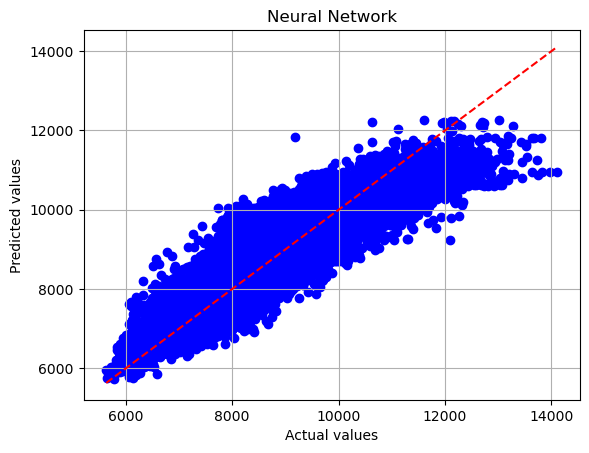

In [126]:
# Get the best model from hyperparameter optimization
best_nn_model = nn_optimizer.best_estimator_

# Make predictions on the test data
y_pred = best_nn_model.predict(X_test)

# Print the predicted values
print("Predicted values:")
print(y_pred.shape)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

print('Best Parameters for the NN are:')
print(nn_optimizer.best_params_)

# Plotting the results (optional)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

best performance of the RF model

Predicted values:
(17530,)
The Model performance parameter after HPO using Random Search Optimization in RF algorithm:
Mean Squared Error: 131618.03439886525
Mean Absolute Error: 259.7008580303401
r2_score: 0.9346067698119305
Best Parameters for the RF are:
OrderedDict([('regressor__max_depth', 34), ('regressor__min_samples_leaf', 1), ('regressor__min_samples_split', 2), ('regressor__n_estimators', 939)])


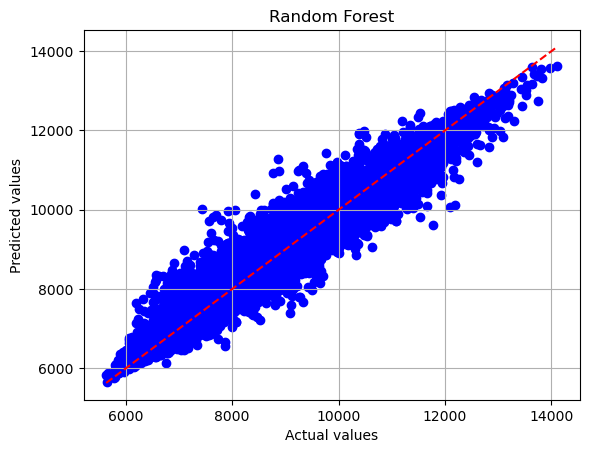

In [127]:
# Get the best model from hyperparameter optimization
best_rf_model = rf_optimizer.best_estimator_

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Print the predicted values
print("Predicted values:")
print(y_pred.shape)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in RF algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

print('Best Parameters for the RF are:')
print(rf_optimizer.best_params_)

# Plotting the results (optional)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.scatter(y_test, y_pred, color='blue')
plt.title('Random Forest')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

hyperparameter optimization for preprocessing

In [128]:
def objective(trial):
    classifier_name = trial.suggest_categorical('regressor', ['RandomForest', 'NN'])
    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        regr = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth ,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, random_state=42)
    else:
        hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 8, 256)
        activation = trial.suggest_categorical('activation',['identity', 'logistic', 'tanh', 'relu'])
        alpha = trial.suggest_float('alpha',1e-5, 1e-2)
        max_iter = trial.suggest_int('max_iter', 10, 100)
        learning_rate_init = trial.suggest_float('learning_rate_init', 0.0001, 0.1)
        
        regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=alpha, max_iter=max_iter,
                            learning_rate_init=learning_rate_init, random_state=42)

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    # Hyperparameters for numeric transformer
    num_imputer_strategy = trial.suggest_categorical('num_imputer_strategy', ['mean', 'median', 'most_frequent'])
    num_scaler = trial.suggest_categorical('num_scaler', ['StandardScaler', 'MinMaxScaler'])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=num_imputer_strategy)),
        ('scaler', StandardScaler() if num_scaler == 'StandardScaler' else MinMaxScaler())
    ])

    # Hyperparameters for categorical transformer
    cat_imputer_strategy = trial.suggest_categorical('cat_imputer_strategy', ['most_frequent', 'constant'])
    cat_encoder_handle_unknown = trial.suggest_categorical('cat_encoder_handle_unknown', ['error', 'ignore'])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=cat_imputer_strategy)),
        ('onehot', OneHotEncoder(handle_unknown=cat_encoder_handle_unknown))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', regr)])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    accuracy = r2_score(y_test, y_pred)

    return accuracy

In [129]:
# Convert X_train and X_test back to pandas DataFrame
# X_train_df = pd.DataFrame(X_train)
# X_test_df = pd.DataFrame(X_test)
X = pd.DataFrame(X)

# Before Optimization process (for the default hyperparameters)
base_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='error'))
        ]), X.select_dtypes(include=['object']).columns)
    ])),
    ('regressor', RandomForestRegressor(random_state=42))
])

base_pipeline.fit(X_train, y_train)
y_base_pred = base_pipeline.predict(X_test)
accuracy_base = r2_score(y_test, y_base_pred)

print("Base Accuracy: {}".format(accuracy_base))

# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# After Optimization
best_trial = study.best_trial
best_params = best_trial.params

print('Optimized Accuracy: {}'.format(best_trial.value))
print("Best Hyperparameters: {}".format(best_params))

vis.plot_optimization_history(study)
vis.plot_slice(study)

[I 2024-05-06 17:45:38,655] A new study created in memory with name: no-name-64832180-58c2-4ad8-a225-79052893cc55


Base Accuracy: 0.9338337673839685


C:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.

[I 2024-05-06 17:45:40,339] Trial 0 finished with value: 0.3153501100507703 and parameters: {'regressor': 'NN', 'hidden_layer_sizes': 73, 'activation': 'identity', 'alpha': 0.0064920912568368315, 'max_iter': 32, 'learning_rate_init': 0.04108252162104657, 'num_imputer_strategy': 'median', 'num_scaler': 'MinMaxScaler', 'cat_imputer_strategy': 'most_frequent', 'cat_encoder_handle_unknown': 'ignore'}. Best is trial 0 with value: 0.3153501100507703.
C:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.

[I 2024-05-06 17:45:41,740] Trial 1 finished with value: 0.3072373974040764 and parameters: {'regressor': 'NN', 'hidden

[I 2024-05-06 17:46:45,640] Trial 16 finished with value: 0.8449683838995219 and parameters: {'regressor': 'RandomForest', 'n_estimators': 56, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'num_imputer_strategy': 'most_frequent', 'num_scaler': 'StandardScaler', 'cat_imputer_strategy': 'constant', 'cat_encoder_handle_unknown': 'error'}. Best is trial 13 with value: 0.8738329339571498.
[I 2024-05-06 17:46:49,131] Trial 17 finished with value: 0.8749540421242425 and parameters: {'regressor': 'RandomForest', 'n_estimators': 31, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'num_imputer_strategy': 'median', 'num_scaler': 'StandardScaler', 'cat_imputer_strategy': 'constant', 'cat_encoder_handle_unknown': 'error'}. Best is trial 17 with value: 0.8749540421242425.
[I 2024-05-06 17:46:56,653] Trial 18 finished with value: 0.8248130811855592 and parameters: {'regressor': 'RandomForest', 'n_estimators': 97, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_le

Optimized Accuracy: 0.8749540421242425
Best Hyperparameters: {'regressor': 'RandomForest', 'n_estimators': 31, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'num_imputer_strategy': 'median', 'num_scaler': 'StandardScaler', 'cat_imputer_strategy': 'constant', 'cat_encoder_handle_unknown': 'error'}


In [130]:
# best hyperparameters are assigned to variables
best_regressor = best_params['regressor']
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_num_imputer_strategy = best_params['num_imputer_strategy']
# hyperparameters for preprocessing

best_num_imputer_strategy = best_params['num_imputer_strategy']
best_num_scaler = best_params['num_scaler']
best_cat_imputer_strategy = best_params['cat_imputer_strategy']
best_cat_encoder_handle_unknown = best_params['cat_encoder_handle_unknown']

# Define the parameter space for Random Forest
rf_param_space = {
    'n_estimators': best_n_estimators,
    'max_depth': best_max_depth,
    'min_samples_split': best_min_samples_split,
    'min_samples_leaf': best_min_samples_leaf
}

# following hyperparameters for preprocessing
hyper_prepro = {
    'num_imputer_strategy':best_num_imputer_strategy, 
    'num_scaler': best_num_scaler,
    'cat_imputer_strategy': best_cat_imputer_strategy,
    'cat_encoder_handle_unknown': best_cat_encoder_handle_unknown,
}

# # predict the result with RF
# best_regressor = RandomForestRegressor(random_state=42, **rf_param_space)
# best_regressor.fit(X_train, y_train)

# # predict the result
# y_pred = best_regressor.predict(X_test)

In [131]:
# performing the preprocessing with the best values after HPO for preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=best_num_imputer_strategy)),
    ('scaler', StandardScaler() if best_num_scaler == 'StandardScaler' else MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=best_cat_imputer_strategy)),
    ('onehot', OneHotEncoder(handle_unknown=best_cat_encoder_handle_unknown))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

regr = RandomForestRegressor()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regr)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = r2_score(y_test, y_pred)

Result of the model after optimization for RF algorithm

The Model performance parameter after HPO using Bayesian Optimizatoin in RF algorithm:
Mean Squared Error: 133591.9353054647
Mean Absolute Error: 261.3727069243754
r2_score: 0.9336260549961892


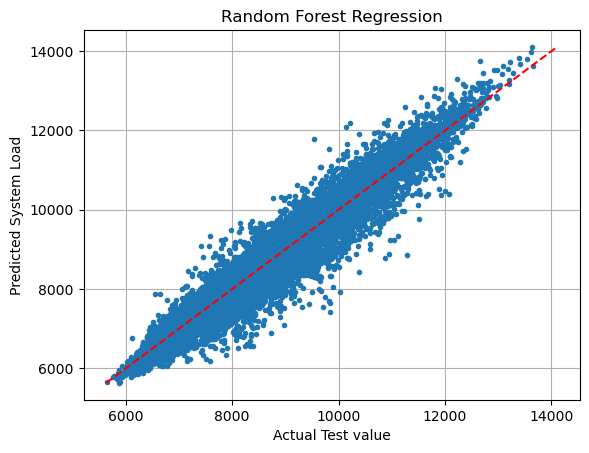

In [132]:
R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("The Model performance parameter after HPO using Bayesian Optimizatoin in RF algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

plt.plot(y_pred,y_test, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.title('Random Forest Regression')
plt.xlabel('Actual Test value')
plt.ylabel('Predicted System Load')
plt.grid(True)
plt.show()

evaluate the model performance now

The Model performance parameter after HPO using Bayesian Optimizatoin in RF algorithm:
Mean Squared Error: 133591.9353054647
Mean Absolute Error: 261.3727069243754
r2_score: 0.9336260549961892


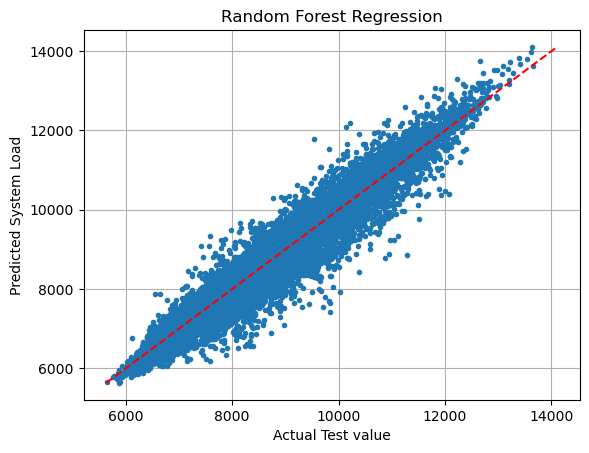

In [133]:
R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("The Model performance parameter after HPO using Bayesian Optimizatoin in RF algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

plt.plot(y_pred,y_test, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.title('Random Forest Regression')
plt.xlabel('Actual Test value')
plt.ylabel('Predicted System Load')
plt.grid(True)
plt.show()

In [134]:
regr = MLPRegressor()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regr)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = r2_score(y_test, y_pred)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



The Model performance parameter after HPO using Random Search Optimization in NN algorithm:
Mean Squared Error: 547656.2675421466
Mean Absolute Error: 602.6200334939634
r2_score: 0.7279019358487595


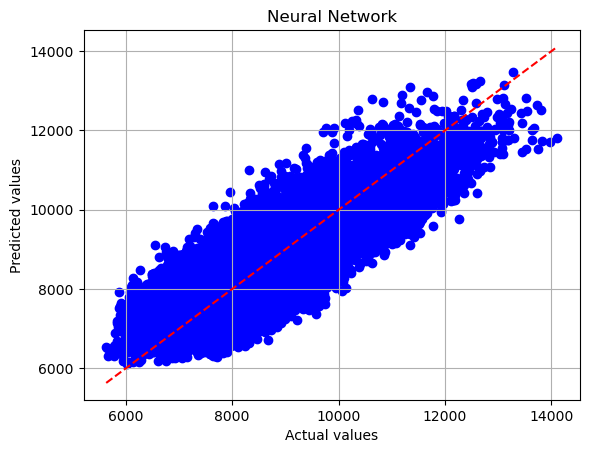

In [135]:
R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

# Plotting the results (optional)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

In [136]:
# Define the pipeline for Random Forest

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy=best_num_imputer_strategy)),
    ('scaler',  StandardScaler() if best_num_scaler == 'StandardScaler' else MinMaxScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the parameter space for Random Forest
# rf_param_space = {
#     'n_estimators': Integer(10, 1000),
#     'max_depth': Integer(3, 40),
#     'min_samples_split': Integer(2, 10),
#     'min_samples_leaf': Integer(1, 5)
# }

rf_param_space = {
    'regressor__n_estimators': Integer(10, 1000),
    'regressor__max_depth': Integer(3, 40),
    'regressor__min_samples_split': Integer(2, 10),
    'regressor__min_samples_leaf': Integer(1, 5)
}

# Perform hyperparameter optimization for Random Forest
rf_optimizer = BayesSearchCV(
    rf_pipeline, 
    rf_param_space, 
    n_iter=20, 
    cv=5, 
    n_jobs=-1
)
rf_optimizer.fit(X_train, y_train)

# Define the pipeline for Neural Network
# values for parameters will be selected from preprocessor
nn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy=best_num_imputer_strategy)),
    ('scaler',  StandardScaler() if best_num_scaler == 'StandardScaler' else MinMaxScaler()),
    ('regressor', MLPRegressor())
])

# Define the parameter space for Neural Network
# nn_param_space = {
#     'hidden_layer_sizes': Integer(8, 256, prior='log-uniform'),
#     # 'regressor__hidden_layer_sizes':[(x, y, z) for x in range(10, 101) 
#     #                                   for y in range(10, 101) 
#     #                                   for z in range(10, 101)],
#     'activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
#     'alpha': Real(1e-5, 1e-2, prior='log-uniform'),
#     'max_iter': Integer(10, 100),
#     'learning_rate_init': Real(0.0001, 0.1, prior='log-uniform')
# }

nn_param_space = {
    'regressor__hidden_layer_sizes': Integer(8, 256, prior='log-uniform'),
    'regressor__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'regressor__alpha': Real(1e-5, 1e-2, prior='log-uniform'),
    'regressor__max_iter': Integer(10, 100),
    'regressor__learning_rate_init': Real(0.0001, 0.1, prior='log-uniform')
}


# Perform hyperparameter optimization for Neural Network
nn_optimizer = BayesSearchCV(
    nn_pipeline, 
    nn_param_space, 
    n_iter=20, 
    cv=5, 
    n_jobs=-1
)
nn_optimizer.fit(X_train, y_train)

# Evaluate the best models
rf_best_score = rf_optimizer.best_score_
nn_best_score = nn_optimizer.best_score_

print(f"Best Random Forest score: {rf_best_score}")
print(f"Best Neural Network score: {nn_best_score}")


Best Random Forest score: 0.9277332071320142
Best Neural Network score: 0.8636858712596227


C:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



Neural Network Model for prediction and performance evaluation

Predicted values:
(17530,)
The Model performance parameter after HPO using Random Search Optimization in NN algorithm:
Mean Squared Error: 397228.7157783409
Mean Absolute Error: 438.9131921480781
r2_score: 0.8026405046478322


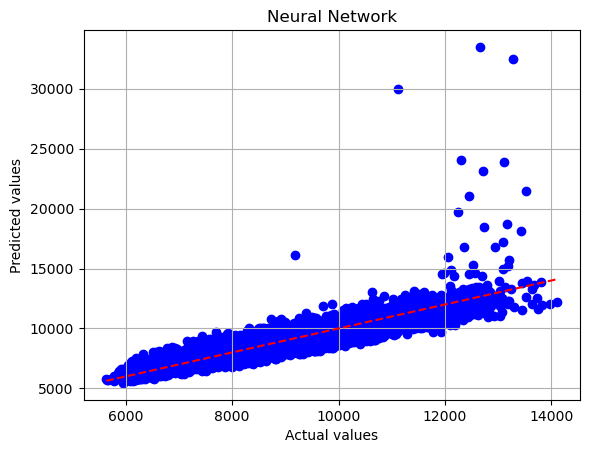

In [137]:
# Get the best model from hyperparameter optimization
best_nn_model = nn_optimizer.best_estimator_

# Make predictions on the test data
y_pred = best_nn_model.predict(X_test)

# Print the predicted values
print("Predicted values:")
print(y_pred.shape)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

# Plotting the results (optional)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

using random forest method for prediction and performance evaluation

Predicted values:
(17530,)
The Model performance parameter after HPO using Random Search Optimization in RF algorithm:
Mean Squared Error: 131529.2585305997
Mean Absolute Error: 259.5866549292246
r2_score: 0.9346508772992907


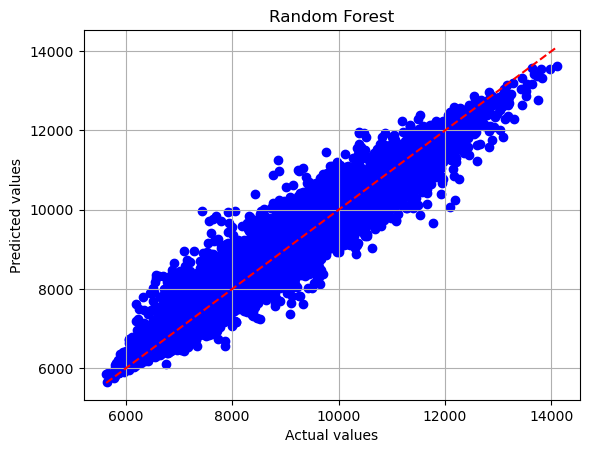

In [138]:
# Get the best model from hyperparameter optimization
best_rf_model = rf_optimizer.best_estimator_

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Print the predicted values
print("Predicted values:")
print(y_pred.shape)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in RF algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

# Plotting the results (optional)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.scatter(y_test, y_pred, color='blue')
plt.title('Random Forest')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()